In [9]:
import sys
import numpy as np
import pandas as pd
import importlib
import os


import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import glob
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd


%matplotlib notebook

In [10]:
inputdirectory = "/Users/naila/Documents/DATA/PREPROCESSED/Jonas Ort/ID046"

In [11]:
timestr = time.strftime("%d%m%Y")


### Import of all Custom Functions

In [12]:

def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
    
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y    
    

In [14]:
# set filter cuts in Hz
lowcut = 150
highcut = 4500

# Length of cutouts around shapes
pre = 0.001 # 1 ms
post= 0.002 # 2 ms


# get filelist
os.chdir(inputdirectory)
filelist= glob.glob("*.h5")


resting_spikedic={}
spikedic={}
spikedic_MAD={}
artefactsdic_MAD={}
cutouts_dic ={} 
keylist = []

In [15]:
# choose the file for filtering
filelist

['2021-05-17T11-08-01__cortex_div11_aCSF_ID046_nodrug_spont_1__.h5',
 '2021-05-17T11-30-44__cortex_div11_aCSF_ID046_30µMNE_spont_2__.h5',
 '2021-05-17T11-10-03__cortex_div11_aCSF_ID046_nodrug_spont_2__.h5',
 '2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNE_spont_1__.h5']

In [16]:
filename = filelist[1]

In [17]:
filedatebase = filename.split('T')[0]
filenamebase = filename.split('__')[1]
filebase = filedatebase + '_' + filenamebase
print('Working on file: ' +filename)
channel_raw_data = McsPy.McsData.RawData(filename)
get_channel_infos(inputdirectory, filename)

Working on file: 2021-05-17T11-30-44__cortex_div11_aCSF_ID046_30µMNE_spont_2__.h5
Recording_0 <HDF5 group "/Data/Recording_0" (2 members)>
{0: <Recording label=, AnalogStreams=3, EventStreams=1, duration_time=240200000 microsecond>}

2021-05-17 11:30:44.362736
Montag, 17. Mai 2021
637568478443627399
8b3032f1-6675-485b-9201-bfa23eb66bb2
256MEA

MEA_256MEA_MEA2100_252_6
Multi Channel Experimenter
2.15.0.20098
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 6005000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 6005000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape

In [19]:
# import of the analogstream with the recording data
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
stream = analog_stream_0
for key in stream.channel_infos.keys():
    keylist.append(key)

In [20]:
# we assign all basic info of that recording to parameters

channel_id = keylist[0]
tick = stream.channel_infos[channel_id].info['Tick']
time = stream.get_channel_sample_timestamps(channel_id)
first_recording_timepoint = time[0][0]
scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
time_in_sec = time[0]*scale_factor_for_second
timelengthrecording_ms = time[0][-1]+tick
timelengthrecording_s = (time[0][-1]+tick)*scale_factor_for_second
fs = int(stream.channel_infos[channel_id].sampling_frequency.magnitude)

In [21]:
# import the actual data 

analog_stream_0_data = analog_stream_0.channel_data
np_analog_stream_0_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
    

In [22]:
# the data is now transposed
np_analog_for_filter = np.transpose(np_analog_stream_0_data)
np_analog_stream_1_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
np_analog_stream_1_data_transpose = np.transpose(np_analog_stream_1_data)

In [23]:
np_analog_stream_1_data_transpose.shape

(252, 6005000)

In [24]:
# choose the correct channel you want to plot
labellist = get_MEA_Channel_labels(np_analog_for_filter)

# make a dictionary so we can reverse search
label_number_dic = {}
for i in range(0, len(labellist)):
    channel_label = labellist[i]
    label_number_dic[channel_label] = i

In [64]:
channel_idx = label_number_dic['J2']
channellabel = labellist[channel_idx]

In [65]:
signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, channel_idx)
bandpassfilteredsignal = butter_bandpass_filter(
    signal_in_uV, lowcut, highcut, sampling_frequency
    )

In [66]:
np.shape(signal_in_uV)

(6005000,)

### for whole dictionary with all bandpass and lowpass filtered signals



<IPython.core.display.Javascript object>


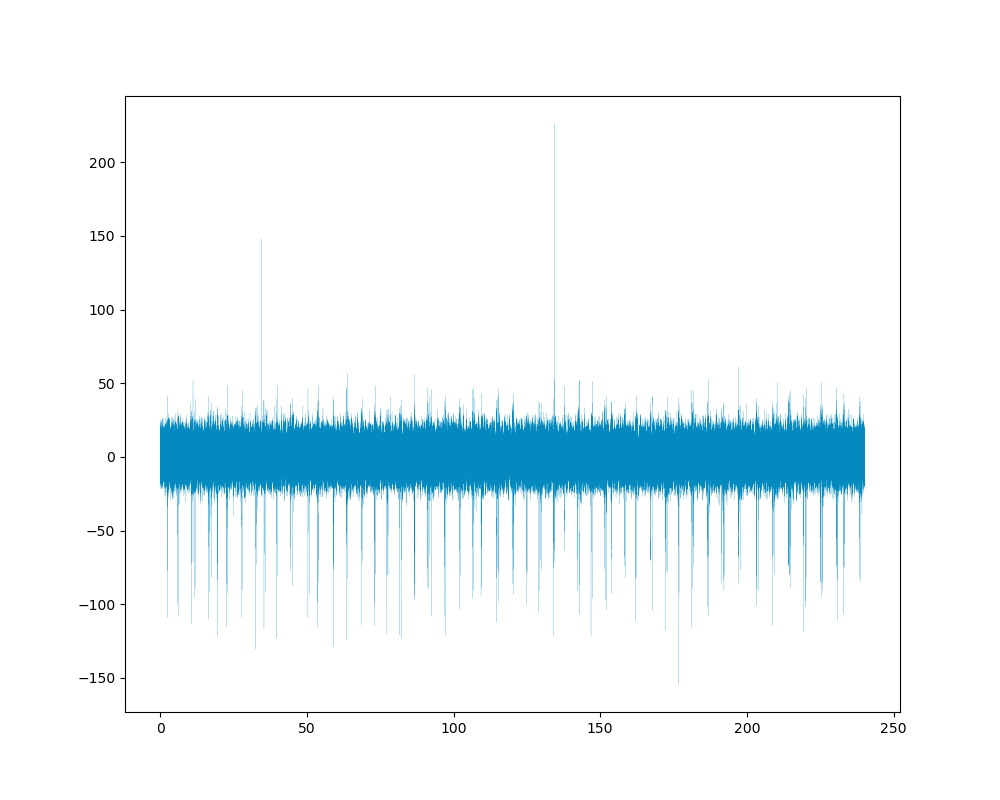

In [67]:
# plot the signal and the filter

fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.1)
#ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.5)

In [68]:
# Filter requirements.
T = timelengthrecording_s         # Sample Period
fs = fs      # sample rate, Hz
cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [69]:
nyq

12500.0

In [70]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [71]:
butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)

In [72]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

<IPython.core.display.Javascript object>


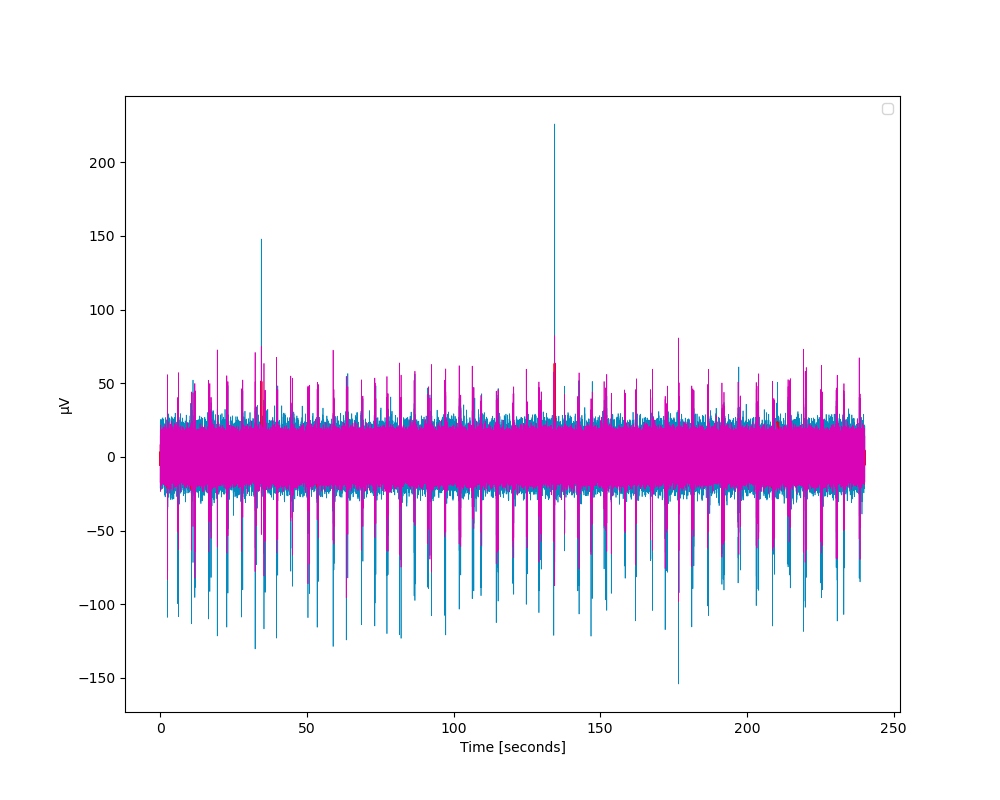

No handles with labels found to put in legend.


In [73]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec, butter_lowpass_filtered_signal, c = '#F20505', linewidth = 1.5)
ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.5)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('µV')
ax.legend()

/var/folders/02/pmnx11bd3pj4tq8tdxbwt53w0000gn/T/ipykernel_23540/3091133691.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start = np.int(desired_time_interval[0]/(scale_factor_for_second*tick))
/var/folders/02/pmnx11bd3pj4tq8tdxbwt53w0000gn/T/ipykernel_23540/3091133691.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisi

<IPython.core.display.Javascript object>


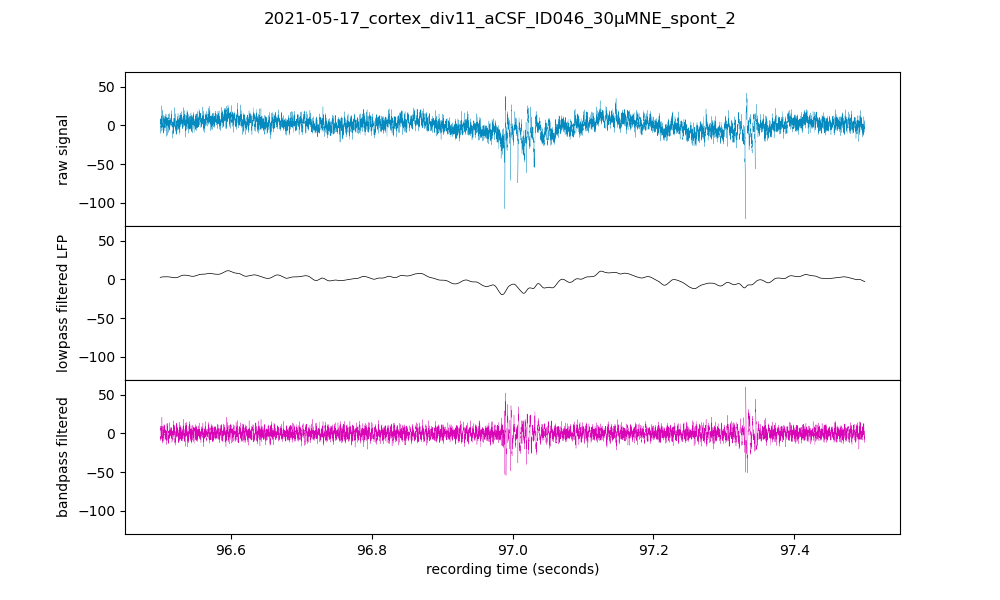

In [74]:
desired_time_interval = (96.5, 97.5)

start = np.int(desired_time_interval[0]/(scale_factor_for_second*tick))
stop = np.int(desired_time_interval[1]/(scale_factor_for_second*tick))






fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(3, hspace = 0, height_ratios=[1,1,1])
axs = gs.subplots(sharex=True, sharey=True)
axs[0].plot(time_in_sec[start:stop], signal_in_uV[start:stop], c = '#048ABF',  linewidth = 0.2)
axs[0].set_ylabel('raw signal')
axs[1].plot(time_in_sec[start:stop], butter_lowpass_filtered_signal[start:stop], c = 'black', linewidth = 0.5)
axs[1].set_ylabel('lowpass filtered LFP')
axs[2].plot(time_in_sec[start:stop], bandpassfilteredsignal[start:stop], c = '#D904B5', linewidth = 0.2)
axs[2].set_ylabel('bandpass filtered')
axs[2].set_xlabel('recording time (seconds)')
fig.suptitle(filename)

#for ax in axs:
#    for i in bursts_seconds:
#        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
fig.savefig(filename+ '__raster_firingrate_plot_solo.png', dpi=300)
fig.savefig(filename+ '__raster_firingrate_plot_solo.eps', dpi=300)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.pdf', dpi=300)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.svg', dpi=300)

In [75]:
noise_mad = np.median(np.absolute(bandpassfilteredsignal)) / 0.6745
threshold = -5* noise_mad
artefact_threshold = -8* noise_mad
crossings = detect_threshold_crossings(
    bandpassfilteredsignal, sampling_frequency, 
    threshold, dead_time=0.003
    )
spikes=align_to_minimum(
    bandpassfilteredsignal, fs, crossings, search_range=0.003, 
    first_time_stamp=first_recording_timepoint
    )

In [76]:
len(spikedic_MAD['J2'])

533

<IPython.core.display.Javascript object>


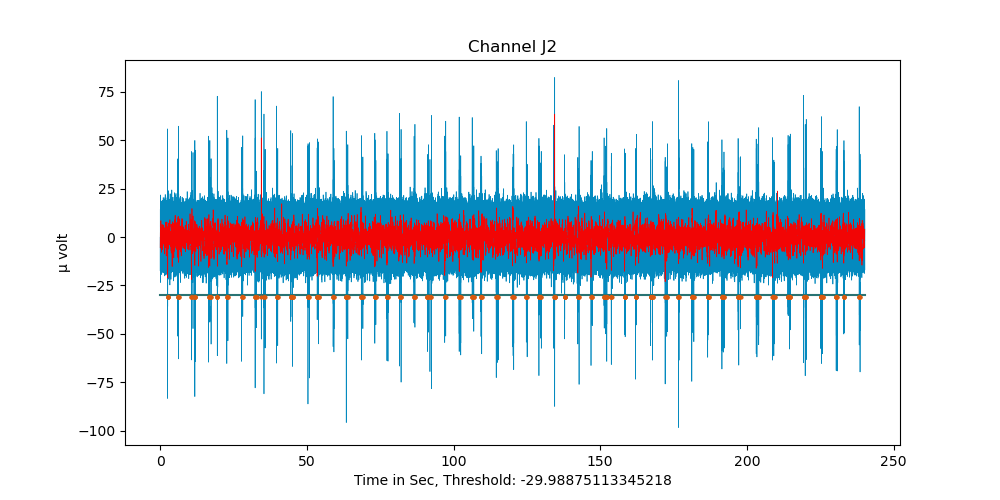

/var/folders/02/pmnx11bd3pj4tq8tdxbwt53w0000gn/T/ipykernel_23540/2342890759.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [77]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [threshold, threshold], c="#297373")
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec, Threshold: %s' %threshold)
ax = plt.ylabel('µ volt')

#fig.savefig(filebase+'_signal_'+channellabel+'_Spikes_and_LFP.png')

In [78]:
len(butter_lowpass_filtered_signal)

6005000

In [79]:
# we want to find where the lfp passes a mean threshold

lfp_mean = np.mean(butter_lowpass_filtered_signal)
lfp_std = np.std(butter_lowpass_filtered_signal)

In [80]:
lfp_mean, lfp_std

(-0.028640351140225232, 4.203369169668711)

In [81]:
def lfp_crossing_detection(lowpass_filtered_signal, lfp_threshold):

    # dicts will have tuples with a start and stop of the lfp crossing
    lfp_up_crossing = []
    lfp_down_crossing = []
    
    # lfp crosses below threshold
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] < -lfp_threshold) and (lowpass_filtered_signal[i-1] >= -lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] < -lfp_threshold:
                stop = i
                i += 1
            lfp_down_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
    # lfp crosses above threshold
    
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] > lfp_threshold) and (lowpass_filtered_signal[i-1] <= lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] > lfp_threshold:
                stop = i
                i += 1
            lfp_up_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
            
    return lfp_down_crossing, lfp_up_crossing
            
            
    

In [82]:
down_cross, up_cross = lfp_crossing_detection(butter_lowpass_filtered_signal, (3*lfp_std))

In [83]:
down_cross

[(2.53864, 2.5512),
 (4.06044, 4.0725999999999996),
 (6.2664, 6.26948),
 (10.609839999999998, 10.624959999999998),
 (10.634839999999999, 10.653439999999998),
 (11.796039999999998, 11.805959999999999),
 (13.079719999999998, 13.09164),
 (16.471799999999998, 16.47852),
 (16.90064, 16.9086),
 (19.47568, 19.4846),
 (19.4936, 19.501079999999998),
 (22.737, 22.757679999999997),
 (27.76512, 27.772039999999997),
 (27.7792, 27.78024),
 (32.34856, 32.359959999999994),
 (40.06008, 40.061),
 (42.317840000000004, 42.332679999999996),
 (53.50411999999999, 53.51631999999999),
 (53.54728, 53.55136),
 (58.94148, 58.949799999999996),
 (58.97644, 58.97952),
 (63.42512, 63.432680000000005),
 (63.72116, 63.722719999999995),
 (73.14932, 73.15692),
 (73.19984, 73.20752),
 (77.29484, 77.30143999999999),
 (77.31804, 77.32092),
 (77.33856, 77.3414),
 (82.57132, 82.57755999999999),
 (84.05771999999999, 84.07415999999999),
 (86.5572, 86.5624),
 (96.97868, 96.99171999999999),
 (97.00919999999999, 97.02156000000001)

In [84]:
up_cross

[(10.809959999999998, 10.823039999999999),
 (10.827, 10.84288),
 (18.04396, 18.05948),
 (34.45692, 34.4698),
 (39.032639999999994, 39.04016),
 (41.41255999999999, 41.43428),
 (53.64184, 53.6534),
 (53.66788, 53.67847999999999),
 (68.45591999999999, 68.47015999999999),
 (78.59143999999999, 78.59576),
 (103.45156, 103.45308),
 (103.46992, 103.48244),
 (108.57764, 108.5872),
 (114.68736, 114.70407999999999),
 (120.18776, 120.19072),
 (120.21152, 120.25003999999998),
 (120.27391999999999, 120.28191999999999),
 (134.47104, 134.48796),
 (142.5296, 142.57487999999998),
 (142.59912, 142.60268),
 (142.60692, 142.61939999999998),
 (142.62972, 142.6344),
 (151.44976, 151.45479999999998),
 (161.19547999999998, 161.2004),
 (163.65488, 163.65828),
 (181.32416, 181.34215999999998),
 (181.37311999999997, 181.38436),
 (189.50848000000002, 189.52116),
 (197.3678, 197.37244),
 (199.77239999999998, 199.77652),
 (206.65316, 206.65851999999998),
 (208.91403999999997, 208.916),
 (208.92899999999997, 208.9307

<IPython.core.display.Javascript object>


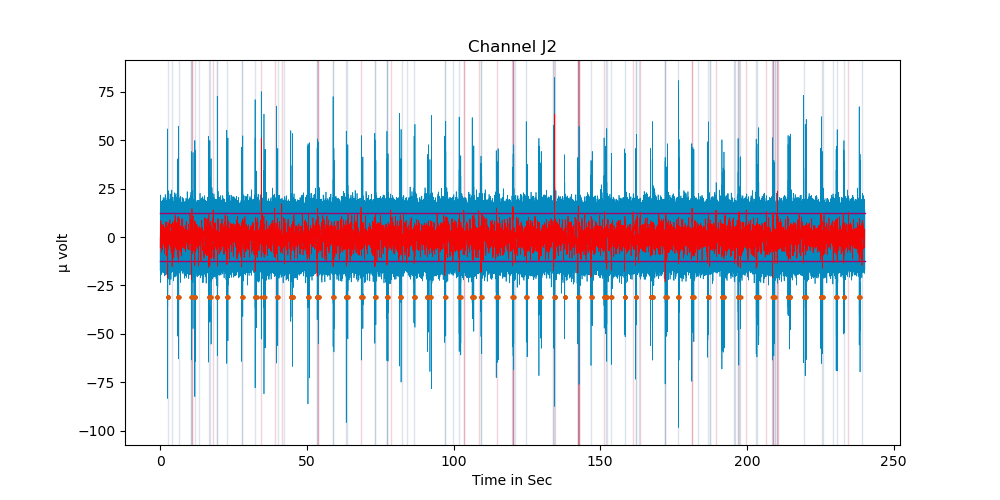

/var/folders/02/pmnx11bd3pj4tq8tdxbwt53w0000gn/T/ipykernel_23540/1868356386.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [85]:
# plot the lfps

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [3*lfp_std, 3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-3*lfp_std, -3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')

In [88]:
interesting_lfp = ['J2', 'J3', 'K2', 'K3', 'J13', 'J14', 'K13', 'K14', 'F15', 'E15']

bandpass_dic={}
lowpass_dic={}


for i in interesting_lfp:
    channellabel = i
    labellist = get_MEA_Channel_labels(np_analog_for_filter)
    signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, channel_idx)
    bandpassfilteredsignal = butter_bandpass_filter(
        signal_in_uV, lowcut, highcut, sampling_frequency
        )
    
    # get the lowpass signal
    # Filter requirements.
    T = timelengthrecording_s         # Sample Period
    fs = fs      # sample rate, Hz
    cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    
    butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)
    
    bandpass_dic[channellabel] = bandpassfilteredsignal
    lowpass_dic[channellabel] = butter_lowpass_filtered_signal

In [89]:
lowpass_dic

{'J2': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'J3': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K2': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K3': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'J13': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'J14': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K13': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K14': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'F15': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'E15': array([11.37718047, 11.3

In [90]:
lowpass_dic['J2'][0]

11.377180469486737

In [91]:
# for every channel in our lowpass_dictionary, we want the std*3 for threshold

lowpass_threshold_dic = {}
up_crossing_dic = {}
down_crossing_dic = {}

for key in lowpass_dic:
    std = np.std(lowpass_dic[key])
    lowpass_threshold_dic[key] = std*3
    

# we want the up crossings of the lfp
# and the donwcrossings of the lfp

for key in lowpass_dic:
    
    threshold = lowpass_threshold_dic[key]
    low_signal = lowpass_dic[key]
    
    down_cross, up_cross = lfp_crossing_detection(
        low_signal, threshold)
    
    up_crossing_dic[key] = up_cross
    down_crossing_dic[key] = down_cross

In [96]:
lowpass_signal

11.377180469486737

<IPython.core.display.Javascript object>


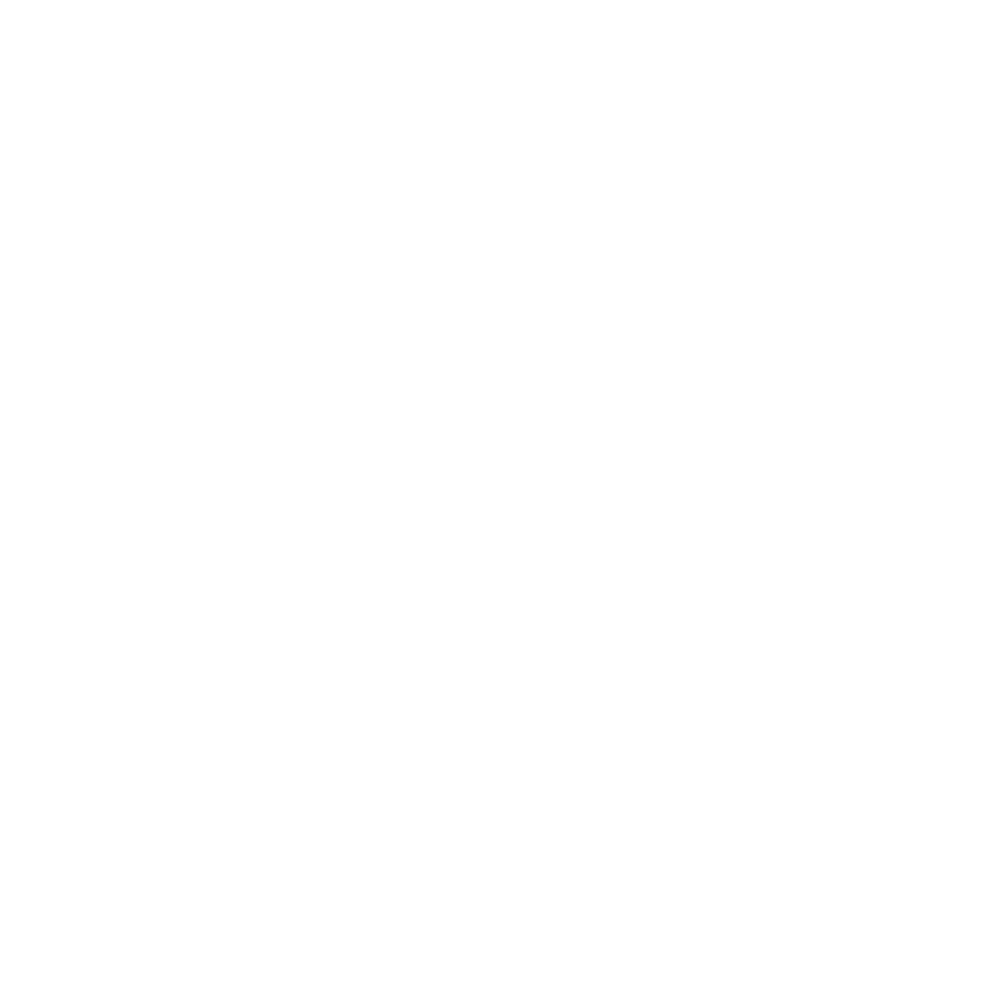

IndexError: index 90.2 is out of bounds for GridSpec with size 10

In [98]:
fig = plt.figure(figsize=(10,10))
limit0 = 89.3
limit1 = 91.2


windowsize = 0.2 #in seconds
win = limit0
windows = []
while win < limit1:
    if win + windowsize >= limit1:
        win = limit1
        windows.append(win)
    else:
        windows.append(win)
        win += windowsize

number_interesting_LFP = len(interesting_lfp)
#fig.tight_layout()
gs1 = gridspec.GridSpec(number_interesting_LFP, 1)
gs1.update(wspace=0.025, hspace=0.05) 
axs = []

for key in bandpass_dic:
    
    # get the key of the channel
    key = key
    
    #no get all signals to plot and the lfp_down and lfp_ups
    bandpass_signal = bandpass_dic[key]
    # in the lowpass_dic there are still additional returns from the old butter filter function
    lowpass_signal = lowpass_dic[key]
    lfp_ups = up_crossing_dic[key]
    lfp_downs = down_crossing_dic[key]
    
    
    axs.append(fig.add_subplot(gs1[i-1]))
    
    
    axs[-1] = plt.plot(time_in_sec, bandpass_signal, c="#048ABF", linewidth = 0.5)
    axs[-1] = plt.plot(time_in_sec, lowpass_signal, c='#F20505', linewidth=1)
    
    # spikes may be added additionally
    #axs[-1] = plt.plot(spikes*tick*scale_factor_for_second, 
     #                  [100]*(spikes*tick*scale_factor_for_second).shape[0], 
      #                 'ro', ms=2, c="#D9580D")

    
    for i in lfp_downs:
        ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
    for i in lfp_ups:
        ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
    for i in windows:
        ax = plt.axvline(i)
    
    # plt xlim for zooming in the time
    plt.xlim(limit0, limit1)    
    plt.yticks(fontsize='xx-small')
    plt.ylabel(key)
    #plt.ylim(-100, 100)
    

fig.suptitle(filebase + ' lfp + banbpass from '+str(limit0)+' to '+str(limit1))
fig.savefig(
    filebase + '_lfp_and_bandpasssignal_cutout_from_' + str(limit0) +'_to_'+str(limit1)+'.png',
    bbox_inches='tight', dpi=300)

In [195]:
spikes

array([1563659, 1563813, 1571219, 1911199, 2181412, 2258293, 2258629,
       2258788, 2259267, 2259367, 2259493, 2259610, 2259762, 2260014,
       2260263, 2262410, 2263298, 2263944, 2264733, 2265672, 2266803,
       2271248, 2271407, 2664734, 2665071, 2665283, 2665420, 2665626,
       2665726, 2665889, 2666044, 2666186, 2666606, 2667118, 2667254,
       2667524, 2668113, 2669111, 2669587, 2670870, 2672165, 2673329,
       2834014, 2834241, 2834367, 2974797], dtype=int64)

In [104]:
lowpass_signal

(array([5.68900865, 5.66306546, 5.63711961, ..., 1.78719673, 1.78716393,
        1.78713201]),
 array([3.91302054e-05, 7.82604108e-05, 3.91302054e-05]),
 array([ 1.        , -1.98222893,  0.98238545]))

In [87]:
bandpass_dic

{'G13': array([0.15240587, 0.98626915, 2.85086618, ..., 4.41586878, 6.29010552,
        8.28649551]),
 'G12': array([ 0.64948349,  3.45910291,  7.87847738, ..., -1.65921053,
        -2.68900204, -1.96463   ]),
 'F16': array([0.20867881, 1.11628415, 2.44812598, ..., 2.22131436, 2.74884864,
        4.74255338]),
 'F15': array([ 0.81126818,  4.26813203,  9.56608197, ..., -6.68994557,
        -4.40205936, -1.73453422]),
 'F14': array([ 0.29777763,  1.54977308,  3.31574514, ..., -1.0963439 ,
        -1.03260022, -1.08972174]),
 'F13': array([0.1617847 , 0.98722675, 2.6202342 , ..., 1.36133291, 0.58687532,
        0.21216949]),
 'F12': array([ 0.88395406,  4.62491457, 10.20126516, ..., -2.62601538,
        -2.77000523, -3.05608211]),
 'E16': array([ 0.75968466,  3.86895467,  8.11199533, ..., -1.66490566,
        -3.49241667, -4.3414667 ]),
 'E15': array([ 0.1219247 ,  0.8377852 ,  2.53280444, ..., -0.23542396,
         1.13167213,  1.79729714]),
 'E14': array([ 0.08909882,  0.64216774,  2.26

In [ ]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig('divided_burst_spatial_10082021_b25.png', dpi=300, bbox_inches = 'tight')

In [129]:
filename

'2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_2'

In [42]:
np.linspace(0, 2 * np.pi, num=100)

array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

In [43]:
np.cos(np.linspace(0, 2 * np.pi, num = 100))

array([ 1.        ,  0.99798668,  0.99195481,  0.9819287 ,  0.9679487 ,
        0.95007112,  0.92836793,  0.90292654,  0.87384938,  0.84125353,
        0.80527026,  0.76604444,  0.72373404,  0.67850941,  0.63055267,
        0.58005691,  0.52722547,  0.47227107,  0.41541501,  0.35688622,
        0.29692038,  0.23575894,  0.17364818,  0.1108382 ,  0.04758192,
       -0.01586596, -0.07924996, -0.14231484, -0.20480667, -0.26647381,
       -0.32706796, -0.38634513, -0.44406661, -0.5       , -0.55392006,
       -0.60560969, -0.65486073, -0.70147489, -0.74526445, -0.78605309,
       -0.82367658, -0.85798341, -0.88883545, -0.91610846, -0.93969262,
       -0.95949297, -0.97542979, -0.98743889, -0.99547192, -0.99949654,
       -0.99949654, -0.99547192, -0.98743889, -0.97542979, -0.95949297,
       -0.93969262, -0.91610846, -0.88883545, -0.85798341, -0.82367658,
       -0.78605309, -0.74526445, -0.70147489, -0.65486073, -0.60560969,
       -0.55392006, -0.5       , -0.44406661, -0.38634513, -0.32

In [47]:
sig_neo = AnalogSignal(bandpassfilteredsignal, sampling_rate=25000*pq.Hz, units='mV')

In [48]:
sig_neo

AnalogSignal with 1 channels of length 3010000; units mV; datatype float64 
sampling rate: 25000.0 Hz
time: 0.0 s to 120.4 s

In [52]:
freq, psd = welch_psd(sig_neo)

In [53]:
freq, psd

(array([0.00000000e+00, 3.73754650e-02, 7.47509299e-02, ...,
        1.24999252e+04, 1.24999626e+04, 1.25000000e+04]) * Hz,
 array([[3.37487892e-08, 1.68743888e-08, 5.46382557e-22, ...,
         3.81985992e-32, 3.97097524e-32, 1.95987874e-32]]) * mV**2/Hz)

In [54]:
freq.shape

(334445,)

In [55]:
psd.shape

(1, 334445)

<IPython.core.display.Javascript object>


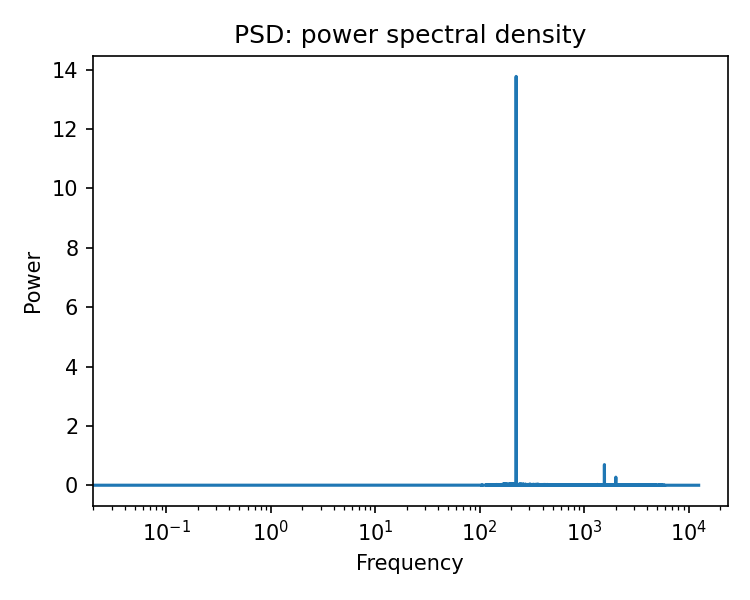

In [61]:


plt.figure(figsize=(5, 4))
plt.semilogx(freq, psd[0])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [47]:
working_directory = '/Users/naila/Documents/DATA/PREPROCESSED/Jonas Ort/ID046/output/2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_2'

In [48]:
os.chdir(working_directory)

In [49]:
filename=working_directory.split('/')[-1]
import pickle

In [50]:
MAIN_RECORDING_DICTIONARY = pickle.load(open('MAIN_RECORDING_Dictionary_'+filename+'.pkl', "rb"))

In [51]:
spikedic_MAD = MAIN_RECORDING_DICTIONARY['spikedic_MAD']
tick = MAIN_RECORDING_DICTIONARY['Infos_Recording']['tick']
timelengthrecording_s = MAIN_RECORDING_DICTIONARY['Infos_Recording']['timelengthrecording_s']
info_dics_subrecordings = MAIN_RECORDING_DICTIONARY['Infos_Recording']['info_dics_subrecordings']
first_recording_timepoint = info_dics_subrecordings['0_to_120']['first_recording_timepoint']
scale_factor_for_second = MAIN_RECORDING_DICTIONARY['Infos_Recording']['scale_factor_for_second']
relevant_factor = timelengthrecording_s*0.05
fr_dic = MAIN_RECORDING_DICTIONARY['fr_dic']


In [86]:
spikedic_MAD

{'G13': [149295,
  150175,
  150381,
  567210,
  567620,
  568228,
  861553,
  861598,
  861712,
  884076,
  884490,
  884686,
  1337405,
  1337605,
  1338128,
  2310573,
  2310648,
  2311186,
  2505788,
  2681140,
  2733571,
  3354357,
  3355060,
  3361968,
  3361988,
  3362113,
  3671521,
  4050810,
  4050888,
  4051482,
  4051573,
  4053751,
  4303062,
  4304036,
  4416199,
  4416603,
  4416689,
  5079427,
  5369098,
  5369191,
  5826003,
  5826007,
  5826025,
  5826310,
  5826565],
 'G12': [149428,
  861554,
  861596,
  861715,
  3354236,
  3354550,
  3361963,
  3361987,
  3362116,
  5826493],
 'F16': [861554, 3361970, 3361986, 3362097],
 'F15': [149079,
  149385,
  149466,
  149490,
  149568,
  149644,
  149727,
  149819,
  149970,
  150173,
  150296,
  150511,
  150580,
  150933,
  151159,
  151428,
  151665,
  152645,
  153485,
  154504,
  155412,
  155524,
  156557,
  156725,
  158495,
  558839,
  567219,
  567321,
  567399,
  567468,
  567507,
  567615,
  567690,
  567816,
  5

In [89]:
spikes = spikedic_MAD['J2']

In [91]:
len(spikes)

533

In [92]:
cutouts = extract_waveforms(bandpassfilteredsignal, 25000, spikes, 
        0.001, 0.003
        )

In [56]:
im = np.arange((-pre*1000), 0.003*1000, 1e3/fs)
im

array([-1.0000000e+00, -9.6000000e-01, -9.2000000e-01, -8.8000000e-01,
       -8.4000000e-01, -8.0000000e-01, -7.6000000e-01, -7.2000000e-01,
       -6.8000000e-01, -6.4000000e-01, -6.0000000e-01, -5.6000000e-01,
       -5.2000000e-01, -4.8000000e-01, -4.4000000e-01, -4.0000000e-01,
       -3.6000000e-01, -3.2000000e-01, -2.8000000e-01, -2.4000000e-01,
       -2.0000000e-01, -1.6000000e-01, -1.2000000e-01, -8.0000000e-02,
       -4.0000000e-02,  8.8817842e-16,  4.0000000e-02,  8.0000000e-02,
        1.2000000e-01,  1.6000000e-01,  2.0000000e-01,  2.4000000e-01,
        2.8000000e-01,  3.2000000e-01,  3.6000000e-01,  4.0000000e-01,
        4.4000000e-01,  4.8000000e-01,  5.2000000e-01,  5.6000000e-01,
        6.0000000e-01,  6.4000000e-01,  6.8000000e-01,  7.2000000e-01,
        7.6000000e-01,  8.0000000e-01,  8.4000000e-01,  8.8000000e-01,
        9.2000000e-01,  9.6000000e-01,  1.0000000e+00,  1.0400000e+00,
        1.0800000e+00,  1.1200000e+00,  1.1600000e+00,  1.2000000e+00,
      

In [93]:
cutouts.shape

(533, 100)

In [94]:
post = 0.003

<IPython.core.display.Javascript object>


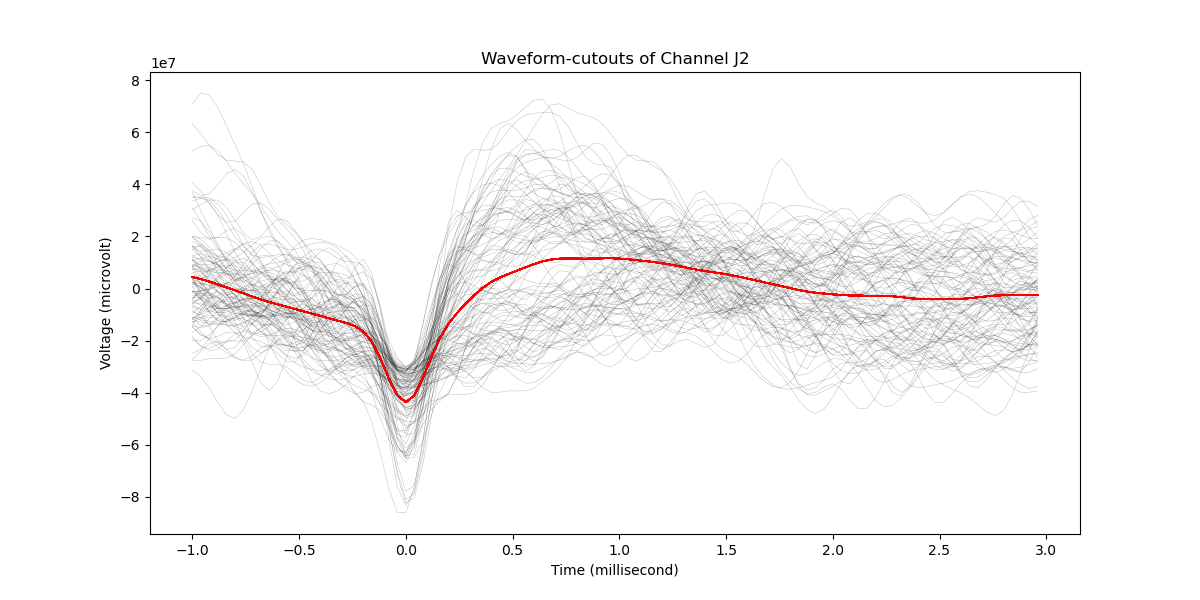

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [101]:
#figure 2: waveforms 
fig2, ax2 = plt.subplots(1, 1, figsize=(12,6))
#ax2 is a plot of the waveform cutouts
n = 100
n = min(n, cutouts.shape[0])
time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
cutout_mean = np.mean(cutouts, axis=0)
for i in range(n):
    ax2 = plt.plot(time_in_us, cutouts[i,]*1e6, color='black', linewidth=0.3, alpha=0.3)
    ax2 = plt.plot(time_in_us, cutout_mean*1e6, color="red", linewidth=1, alpha=0.3)
    ax2 = plt.xlabel('Time (%s)' % ureg.ms)
    ax2 = plt.ylabel('Voltage (%s)' % ureg.uV)
    ax2 = plt.title('Waveform-cutouts of Channel %s' %channellabel)

fig2.savefig(filename+'_waveforms_'+channellabel+'MAD_THRESHOLD_03.eps', dpi=300, bbox_inches = 'tight')


In [99]:
os.chdir('/Users/naila/Documents/plots_feldmeyerpaper/new_041122')